In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

from py_bullet_env.bullet_solo_env import SoloBulletEnv

In [2]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 2048)
        self.l2 = nn.Linear(2048, 2048)
        self.l3 = nn.Linear(2048, 1024)
        self.l4 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [3]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(3, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))        
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,4:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 350)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

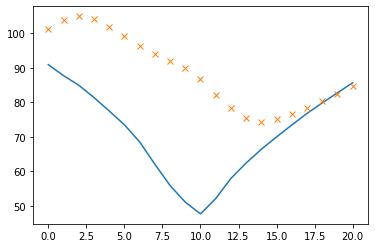

In [7]:
## visualising the q values
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/oned/dqs_3_old', no_actions = 21)
q_arr = []
q_arr.append(dqs.predict_q([0.0, 0]))
# print(q_arr[0])

q_arr.append(dqs.predict_q([0.0, 0.5]))

plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[0])
plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[1], 'x')
plt.show()

In [41]:
# This block shows simulation of the dq stepper
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [0, 0, 1], no_actions=21)

state = env.reset_env([0.0, 0.5], no_steps*step_time)
epi_cost = 0
history = {"state" : [], "q_value" : []}
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
#     print(action)
    next_state, cost, done = env.step_env(action, step_time)
    history["q_value"].append(dqs.predict_q(state))
    history["state"].append(state)
    state = np.around(next_state, 2)
    epi_cost += cost
    if done:
        break
print(epi_cost)
print("showing simulation...")  
# env.show_episode(5, 1)


6.0
showing simulation...


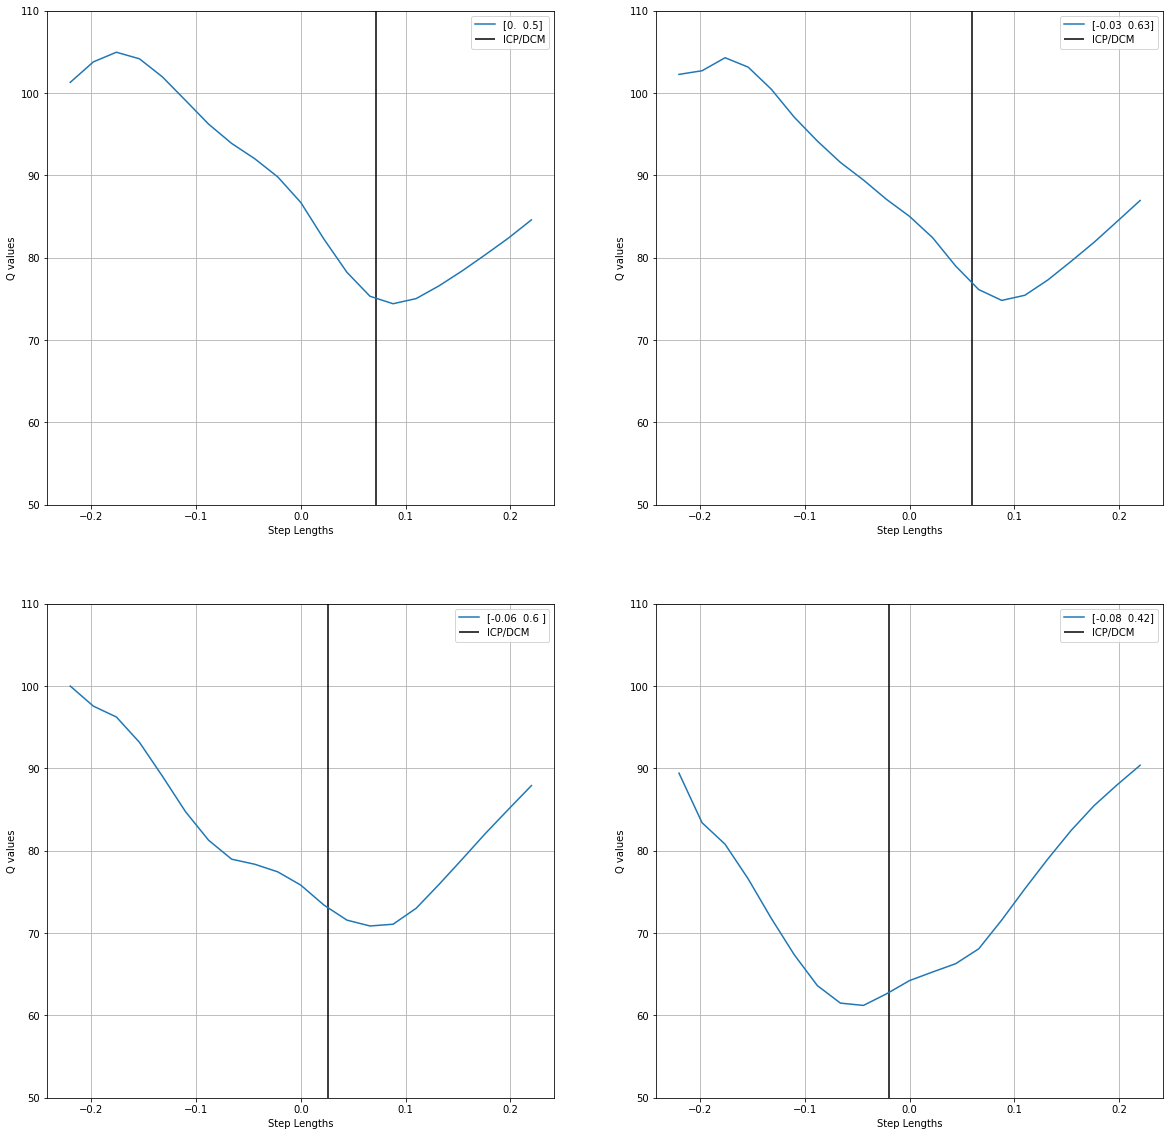

In [42]:
# This block is to generate plots in the paper to compare the q values with the actual dcm location

def compute_dcm(state, ht):
    return state[0] + np.sqrt(ht/9.81)*state[1]

def plot(history, env, no_steps, ht):
    fig, axs = plt.subplots(int(no_steps/2), 2, figsize = [20, 20])
    for i in range(int(no_steps/2)):
        axs[i, 0].plot(env.action_space, history["q_value"][2*i], label = str(history["state"][2*i]))
        axs[i, 0].vlines(compute_dcm(history["state"][2*i], ht), 40, 130, label='ICP/DCM')
        axs[i, 1].plot(env.action_space, history["q_value"][2*i + 1], label = str(history["state"][2*i + 1]))
        axs[i, 1].vlines(compute_dcm(history["state"][2*i + 1], ht), 40, 130, label='ICP/DCM')
        axs[i, 0].set_ylim(50, 110)
        axs[i, 0].set_ylabel('Q values')
        axs[i, 0].set_xlabel('Step Lengths')
        axs[i, 1].set_ylim(50, 110)
        axs[i, 1].set_ylabel('Q values')
        axs[i, 1].set_xlabel('Step Lengths')
        axs[i, 0].legend()    
        axs[i, 1].legend()    
        axs[i, 0].grid()
        axs[i, 1].grid()
    plt.show()

plot(history, env, 4, 0.2)

In [9]:
print(history['state'][1])

[-0.03  0.63]
